In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
from chitaxi.datasets.loader import get_data_taxi, save_as_feather
from chitaxi.datasets.cleaner import Outlier


# %config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2
plt.style.use('seaborn')
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.facecolor'] = 'w'

outlier = Outlier()

# ChiTaxi 01 - Data Exploration & Outlier Detection

## Data Health

In [2]:
data = get_data_taxi(start='20150101', end='20151231')

In [3]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27337211 entries, 6417 to 27336026
Data columns (total 16 columns):
taxi_id                       int64
trip_start_timestamp          datetime64[ns]
trip_end_timestamp            datetime64[ns]
trip_seconds                  float64
trip_miles                    float64
fare                          float64
tips                          float64
tolls                         float64
extras                        float64
trip_total                    float64
payment_type                  object
company                       object
pickup_centroid_latitude      float64
pickup_centroid_longitude     float64
dropoff_centroid_latitude     float64
dropoff_centroid_longitude    float64
dtypes: datetime64[ns](2), float64(11), int64(1), object(2)
memory usage: 6.4 GB


In [4]:
data.head(3)

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude
6417,0,2015-01-01,2015-01-01 00:15:00,360.0,1.0,5.85,0.00,0.0,1.0,6.85,Cash,NaN,41.892042,-87.631864,41.899156,-87.626211
80835,1014,2015-01-01,2015-01-01 00:00:00,0.0,0.0,36.45,7.29,0.0,0.0,43.74,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN
111519,1026,2015-01-01,2015-01-01 00:15:00,360.0,0.0,5.65,0.00,0.0,2.0,7.65,Cash,Taxi Affiliation Services,41.892042,-87.631864,41.899156,-87.626211


In [5]:
print("*100% of data is NA:")
data.isna().sum()/len(data)

*100% of data is NA:


taxi_id                       0.000000
trip_start_timestamp          0.000000
trip_end_timestamp            0.000131
trip_seconds                  0.000224
trip_miles                    0.000002
fare                          0.000006
tips                          0.000006
tolls                         0.000006
extras                        0.000006
trip_total                    0.000006
payment_type                  0.000000
company                       0.352399
pickup_centroid_latitude      0.154228
pickup_centroid_longitude     0.154228
dropoff_centroid_latitude     0.171921
dropoff_centroid_longitude    0.171921
dtype: float64

* `Company` feature has the most null values, around 35%. In this analysis, we probably won't use this feature
* `latitude` and `longtitude` also suffered 16 - 17% null values. However, we are not going to use them in the first stage baseline establishment. Even in the second stage, as data will be aggregated to the monthly level, we hope those missing values will be durable.

## Outlier Detection

From step 1 to 5, we are cleaning the data based on simple data explorations.

* Removing Duplications
* Removing transactions that have little revenues
* Removing transactions that have too large trip distance or extra fees
* Removing invalid transactions that have mismatched start or end time.

For step 6, we are using our own models to detect if the existing fare price is reasonable based on a given pricing formula and quantiles information. More details will be explained the sections below:

### Step 1: Duplications

In [6]:
data = outlier.drop_duplicates(data)

2018-09-25 01:25:52 - INFO - Orignal - Rows: 27337211
2018-09-25 01:25:52 - INFO - Dropping duplications
2018-09-25 01:27:15 - INFO - After Drroping - Rows: 27274021
2018-09-25 01:27:15 - INFO - Drop Ratio: 0.23115%


### Step 2: Drop trips that have \$0 or \$0.1 total values

In [7]:
data = outlier.drop_at_threshhold(data, metric='trip_total', thresh=0.1, islarger=False)

2018-09-25 01:27:15 - INFO - Orignal - Rows: 27274021
2018-09-25 01:27:15 - INFO - Dropping any trip_total less than 0.1
2018-09-25 01:27:45 - INFO - After Drroping - Rows: 27242317
2018-09-25 01:27:45 - INFO - Drop Ratio: 0.11624%


### Step 3: trip_miles>1000

2018-09-25 01:27:51 - INFO - Orignal - Rows: 27242317
2018-09-25 01:27:51 - INFO - Dropping any trip_miles more than 1000
2018-09-25 01:27:57 - INFO - After Drroping - Rows: 27240288
2018-09-25 01:27:57 - INFO - Drop Ratio: 0.00745%


Text(0.5, 1.0, 'Outlier Removed')

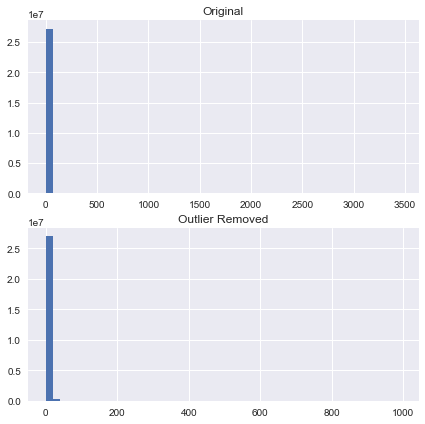

In [8]:
metric = 'trip_miles'
fig, ax = plt.subplots(2,1, figsize=(7,7))
data[metric].hist(ax=ax[0],bins=50)
ax[0].set_title('Original')

data = outlier.drop_at_threshhold(data, metric=metric, thresh=1000)

data[metric].hist(ax=ax[1],bins=50)
ax[1].set_title('Outlier Removed')

### Step 4: extra > 100

2018-09-25 01:28:05 - INFO - Orignal - Rows: 27240288
2018-09-25 01:28:05 - INFO - Dropping any extras more than 100
2018-09-25 01:28:21 - INFO - After Drroping - Rows: 27239040
2018-09-25 01:28:21 - INFO - Drop Ratio: 0.00458%


Text(0.5, 1.0, 'Outlier Removed')

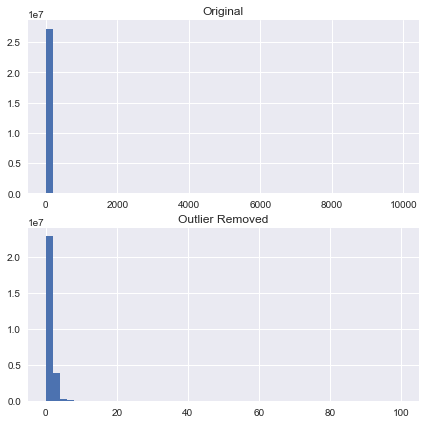

In [9]:
metric = 'extras'
fig, ax = plt.subplots(2,1, figsize=(7,7))
data[metric].hist(ax=ax[0],bins=50)
ax[0].set_title('Original')

data = outlier.drop_at_threshhold(data, metric=metric, thresh=100)

data[metric].hist(ax=ax[1],bins=50)
ax[1].set_title('Outlier Removed')

### Step 5: trip_seconds and trip_total is NaN. (start-time > end-time)

`trip_seconds` are dropped for this step. In those cases, the start time is later than end time (does not make sense).

In [10]:
data = outlier.drop_null_values(data, metric='trip_seconds')

2018-09-25 01:28:26 - INFO - Orignal - Rows: 27239040
2018-09-25 01:28:26 - INFO - Dropping NA values at trip_seconds
2018-09-25 01:28:49 - INFO - After Drroping - Rows: 27236571
2018-09-25 01:28:49 - INFO - Drop Ratio: 0.00906%


In [11]:
data = outlier.drop_null_values(data, metric='trip_total')

2018-09-25 01:28:50 - INFO - Orignal - Rows: 27236571
2018-09-25 01:28:50 - INFO - Dropping NA values at trip_total
2018-09-25 01:29:08 - INFO - After Drroping - Rows: 27236405
2018-09-25 01:29:08 - INFO - Drop Ratio: 0.00061%


### Step 6: Fare outlier

In this section, we will determine if a fare price is reasonable by combining two models:

1. We are using a given pricing formula to calculate a "fair" fare price based on the recorded trip miles and trip seconds. If the price is off too much (judged by its absolute fare difference or absolute percentage difference), we believe it either has a wrong price or wrong miles/seconds. Then those transactions will marked as `Model Outlier` waiting for the next step.
2. We will also apply the well-known IQR method, which is to use the 1.5 times Q1 and Q3 quantiles as the confident lower and upper bound. The dataset will be split into different groups based on the trip_seconds, and IQR will be calculated at each time slot. Since most features are right skewed, we will apply the IQR trick on the log space, in order to have a more right skewed range. 

#### Model the proper fare:

base \$3.25, \$2.25/mile, \$0.25/every 36 seconds, assume 6 passengers: add a passenger head count fee of  \$3.5

https://www.cityofchicago.org/city/en/depts/bacp/supp_info/2012_passenger_information.html

In [12]:
rules = [
    {"thresh": 200, "values": ("abs_fare_diff", 50)},
    {"thresh": np.inf, "values": ("abs_pct_diff", 1)}
]
data = outlier.model_fares_outliers(data, rules)

2018-09-25 01:29:31 - INFO - 0.28076% satisfied rules 0
2018-09-25 01:29:35 - INFO - 3.21494% satisfied rules 1


In [13]:
data.loc[7180:7190,:][['taxi_id', 'trip_seconds', 'trip_miles', 'model_miles','fare', 'model_fare', 'abs_fare_diff', 'abs_fare_diff', 'abs_pct_diff', 'Model_outliers']]

,taxi_id,trip_seconds,trip_miles,model_miles,fare,model_fare,abs_fare_diff,abs_fare_diff,abs_pct_diff,Model_outliers
7180,10,1080.0,6.9,4.429627,16.85,29.775000,12.925000,12.925000,0.434089,0
7181,10,660.0,1.0,0.607257,7.25,13.583333,6.333333,6.333333,0.466258,0
7182,10,2640.0,15.9,13.362553,31.05,60.858333,29.808333,29.808333,0.489799,0
7183,10,1080.0,2.7,2.290734,10.85,20.325000,9.475000,9.475000,0.466175,0
7184,10,1860.0,4.7,3.799229,16.45,30.241667,13.791667,13.791667,0.456048,0
7185,10,720.0,0.0,1.720717,8.65,15.621614,6.971614,6.971614,0.446280,0
7186,10,1380.0,6.4,4.522127,16.65,30.733333,14.083333,14.083333,0.458243,0
7187,10,2040.0,6.0,3.745028,18.25,34.416667,16.166667,16.166667,0.469734,0
7188,10,2520.0,12.8,12.665934,30.65,53.050000,22.400000,22.400000,0.422243,0
7189,10,420.0,1.8,1.799025,7.05,13.716667,6.666667,6.666667,0.486027,0


#### Group the trips in a certain time range (every 10 minutes for trip shorter than 1 hour, every 1 hour for trip longer than 1 hour), log-normal the trip_total and find the outliers based on 1.5IQR rule.

In [14]:
data, report =  outlier.time_range_outliers(data, IQR=1.5)

2018-09-25 01:29:48 - INFO - 00 min ~ 10 min: 6.00822% are outside IQR range
2018-09-25 01:29:55 - INFO - 10 min ~ 20 min: 2.23460% are outside IQR range
2018-09-25 01:29:57 - INFO - 20 min ~ 30 min: 0.03080% are outside IQR range
2018-09-25 01:29:58 - INFO - 30 min ~ 40 min: 2.95886% are outside IQR range
2018-09-25 01:29:58 - INFO - 40 min ~ 50 min: 10.20296% are outside IQR range
2018-09-25 01:29:59 - INFO - 50 min ~ 00 min: 9.90977% are outside IQR range
2018-09-25 01:29:59 - INFO - 01 hr ~ 02 hr: 10.33739% are outside IQR range
2018-09-25 01:30:00 - INFO - 02 hr ~ 03 hr: 11.15826% are outside IQR range
2018-09-25 01:30:00 - INFO - 03 hr ~ 04 hr: 23.18034% are outside IQR range
2018-09-25 01:30:00 - INFO - 04 hr ~ 05 hr: 0.10331% are outside IQR range
2018-09-25 01:30:00 - INFO - 05 hr ~ 06 hr: 0.00000% are outside IQR range
2018-09-25 01:30:00 - INFO - 06 hr ~ 07 hr: 0.00000% are outside IQR range
2018-09-25 01:30:00 - INFO - 07 hr ~ 08 hr: 1.25786% are outside IQR range
2018-09-2

In [15]:
report

,avg_fare,avg_model_fare,lower,time,upper
0,8.047792,11.025545,3.065674,00 min ~ 10 min,17.174040
1,11.336157,19.743235,5.212728,10 min ~ 20 min,25.470830
2,23.871406,37.813061,4.896527,20 min ~ 30 min,128.023912
3,32.000411,50.753552,16.184592,30 min ~ 40 min,84.359571
4,36.458684,59.236546,25.609514,40 min ~ 50 min,69.555986
5,39.464127,65.432369,29.202294,50 min ~ 00 min,68.709071
6,46.277086,75.323406,30.138534,01 hr ~ 02 hr,79.940932
7,76.813751,112.565396,27.720055,02 hr ~ 03 hr,171.059637
8,99.083894,144.100779,30.920214,03 hr ~ 04 hr,230.261747
9,62.097319,134.669964,0.277310,04 hr ~ 05 hr,3197.184464


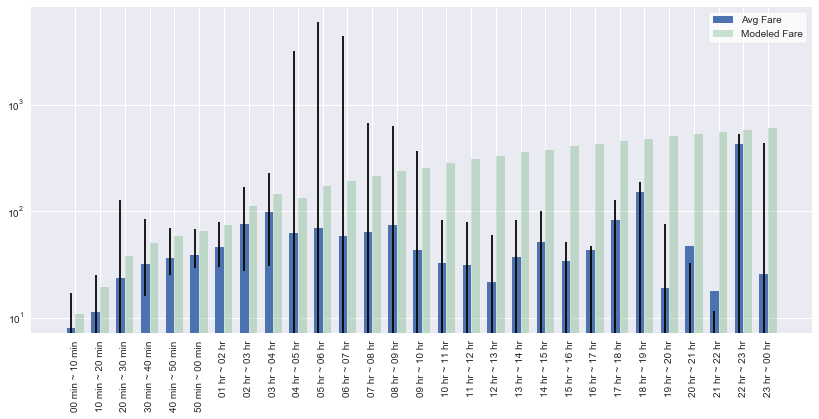

In [23]:
fig, ax = plt.subplots(1,1,figsize=(14,6))

N = len(report['time'])
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

yerr = np.array([report['lower'],  report['upper']])
yerr = [report['avg_fare'].values - yerr[0], yerr[1] - report['avg_fare'].values]
ax.bar(ind, report['avg_fare'], width, yerr=yerr, label='Avg Fare',log=True)
ax.bar(ind + width, report['avg_model_fare'], width, alpha=0.3, label='Modeled Fare',log=True)

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(report['time'], rotation = 90)
l = ax.legend()

In the graph above, we plotted the average realized fare per transaction (blue bar) and the modeled fare prices (green bar) which is simulated based on our pricing formula. The black line is the confidence interval we calculated based on IQR.

* As time increases (trip seconds), our modeled price is therefore increasing as well. However, we noticed the realized price is fluctuating which may indicate some noise in our data. We also noticed for time range 4 - 6hrs, the IQR uppper bound can be 10 times larger than the average upper bound, which may indicate some issues in those periods.

#### Drop rows that satisfy both conditions

In [22]:
cols=['Model_outliers', 'IQR_outlier']
outliers = data[cols][data[cols] == 1].dropna().index

In [25]:
print("{:.5%} dropped".format(len(outliers)/len(data)))

2.96250% dropped


In [26]:
data = data.drop(outliers)
save_as_feather(data, 'clean_2015.feather')

## End-to-end outlier clean for 2016 data

For 2016's dataset, the procedures are basically the same. Then we simply run the `end-to-end` function to replicate what we did with 2015's data.

In [18]:
from chitaxi.datasets import loader


loader.list_feathers()

2015_features.feather
clean_2015.feather
data_2016.feather


In [19]:
df_2016 = loader.read_feather("data_2016.feather")

C:\Users\l5453\Anaconda3\envs\chitaxi\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [21]:
df_2016.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19843680 entries, 0 to 19843679
Data columns (total 17 columns):
index                         int64
taxi_id                       int64
trip_start_timestamp          datetime64[ns]
trip_end_timestamp            datetime64[ns]
trip_seconds                  float64
trip_miles                    float64
fare                          float64
tips                          float64
tolls                         float64
extras                        float64
trip_total                    float64
payment_type                  object
company                       object
pickup_centroid_latitude      float64
pickup_centroid_longitude     float64
dropoff_centroid_latitude     float64
dropoff_centroid_longitude    float64
dtypes: datetime64[ns](2), float64(11), int64(2), object(2)
memory usage: 4.5 GB


In [22]:
outlier = Outlier()
outlier.end_to_end_clean(df_2016, 'clean_2016.feather')

2018-09-24 23:43:38 - INFO - STEP1: Duplications
2018-09-24 23:43:38 - INFO - Orignal - Rows: 19843680
2018-09-24 23:43:38 - INFO - Dropping duplications
2018-09-24 23:44:11 - INFO - After Drroping - Rows: 19802921
2018-09-24 23:44:11 - INFO - Drop Ratio: 0.20540%
2018-09-24 23:44:11 - INFO - 
STEP2: Trips
2018-09-24 23:44:11 - INFO - Orignal - Rows: 19802921
2018-09-24 23:44:11 - INFO - Dropping any trip_total less than 0.1
2018-09-24 23:44:16 - INFO - After Drroping - Rows: 19787102
2018-09-24 23:44:16 - INFO - Drop Ratio: 0.07988%
2018-09-24 23:44:17 - INFO - 
STEP3: Miles
2018-09-24 23:44:17 - INFO - Orignal - Rows: 19787102
2018-09-24 23:44:17 - INFO - Dropping any trip_miles more than 1000
2018-09-24 23:44:21 - INFO - After Drroping - Rows: 19784079
2018-09-24 23:44:21 - INFO - Drop Ratio: 0.01528%
2018-09-24 23:44:21 - INFO - 
STEP4: Extras
2018-09-24 23:44:21 - INFO - Orignal - Rows: 19784079
2018-09-24 23:44:21 - INFO - Dropping any extras more than 100
2018-09-24 23:44:25 - I